In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --- CPU pinning (best-effort) ---
# Pin to the first 2 CPUs when possible for reproducibility/less jitter.
try:
    if hasattr(os, "sched_setaffinity"):
        os.sched_setaffinity(0, {0, 1})
        print("CPU affinity set to cores: 0,1")
    else:
        print("CPU affinity not supported on this platform.")
except Exception as exc:
    print(f"CPU affinity setup skipped: {exc}")


CPU affinity set to cores: 0,1


In [ ]:
from gaussian_channel_learner import GaussianChannelLearner

# --- USAGE EXAMPLE ---
# 1. Define a "Ground Truth" Channel (1 Mode)
# Let's simulate a noisy lossy channel (Attenuation + Thermal Noise)
# Transmission = 50% (eta = 0.5)
# Added Noise = 0.5 shot noise units

eta = 0.5
X_true = np.sqrt(eta) * np.eye(2)

# For a lossy channel, pure vacuum noise output would be (1-eta)*I
# We add EXTRA noise on top to make it 'noisy'
Y_true = (1 - eta) * np.eye(2) + 0.2 * np.eye(2)

# 2. Initialize Learner
learner = GaussianChannelLearner(num_modes=1, true_X=X_true, true_Y=Y_true)

# 3. Step 1: Recover X
est_X = learner.run_drift_protocol(alpha=2.0)
print("Target X:", X_true)
print("Recovered X:", est_X)

# 4. Step 2: Recover Y
est_Y = learner.run_noise_protocol()
print("Target Y:", Y_true)
print("Recovered Y:", est_Y)

# 5. Step 3: Validate
learner.validate_cp_condition()


SyntaxError: unterminated string literal (detected at line 21) (3044793417.py, line 21)

In [4]:
class NoisyChannelSimulator:
    """
    Simulates a Gaussian Channel experiment with finite sampling statistics.
    """
    def __init__(self, N, true_X, true_Y):
        self.N = N
        self.dim = 2 * N
        self.X = true_X
        self.Y = true_Y
        self.hbar = 2.0

    def get_empirical_moments(self, mean_in, cov_in, n_samples):
        """
        Simulates sending 'n_samples' states through the channel and
        calculating the mean and covariance from the noisy data.
        """
        # 1. Theoretical output moments
        mu_out_theory = self.X @ mean_in
        cov_out_theory = self.X @ cov_in @ self.X.T + self.Y

        # 2. Generate finite 'experimental' data (Monte Carlo)
        # simulating homodyne measurement outcomes
        samples = np.random.multivariate_normal(
            mean=mu_out_theory,
            cov=cov_out_theory,
            size=n_samples,
        )

        # 3. Calculate empirical moments from data
        mu_emp = np.mean(samples, axis=0)
        cov_emp = np.cov(samples, rowvar=False)

        return mu_emp, cov_emp

    def run_tomography(self, n_samples, alpha=2.0):
        """
        Runs the full X and Y estimation protocol with finite samples.
        """
        # --- Step A: Estimate X (Drift) ---
        R_in = np.eye(self.dim) * alpha
        R_out_cols = []

        # Covariance of input coherent state (vacuum noise)
        cov_in_coh = np.eye(self.dim) * (self.hbar / 2)

        for k in range(self.dim):
            r_in = R_in[:, k]
            # Measure mean only for X
            mu_hat, _ = self.get_empirical_moments(r_in, cov_in_coh, n_samples)
            R_out_cols.append(mu_hat)

        R_out = np.column_stack(R_out_cols)
        X_est = R_out @ np.linalg.inv(R_in)

        # --- Step B: Estimate Y (Noise) ---
        # Input vacuum
        r_in_vac = np.zeros(self.dim)
        cov_in_vac = np.eye(self.dim) * (self.hbar / 2)

        # Measure covariance for Y
        _, cov_out_hat = self.get_empirical_moments(r_in_vac, cov_in_vac, n_samples)

        # Reconstruct Y using the ESTIMATED X (error propagation matters!)
        Y_est = cov_out_hat - X_est @ cov_in_vac @ X_est.T

        return X_est, Y_est


Running Convergence Analysis...


Sample counts:   0%|          | 0/7 [00:00<?, ?it/s]

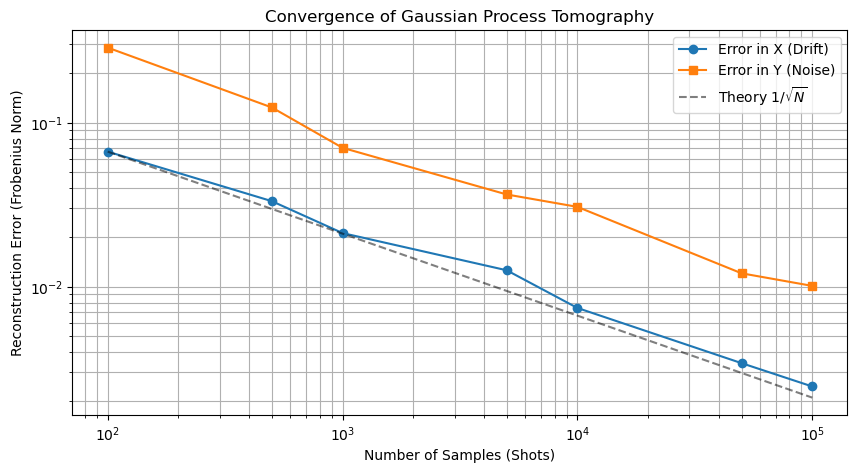

In [5]:
# Define Ground Truth for the tests
N_modes = 1
true_X = np.eye(2) * 0.8  # Lossy channel
true_Y = np.eye(2) * 0.5  # Additive noise
sim = NoisyChannelSimulator(N_modes, true_X, true_Y)

# --- Configuration ---
sample_counts = [100, 500, 1000, 5000, 10000, 50000, 100000]
trials_per_point = 10  # Average over this many trials for smoothness

x_errors = []
y_errors = []

print("Running Convergence Analysis...")
for n in tqdm(sample_counts, desc="Sample counts"):
    x_err_trial = []
    y_err_trial = []

    for _ in range(trials_per_point):
        # Run tomography
        est_X, est_Y = sim.run_tomography(n_samples=n, alpha=3.0)

        # Calculate Frobenius Norm Error (RMSE)
        x_err_trial.append(np.linalg.norm(est_X - true_X, "fro"))
        y_err_trial.append(np.linalg.norm(est_Y - true_Y, "fro"))

    x_errors.append(np.mean(x_err_trial))
    y_errors.append(np.mean(y_err_trial))

# --- Plotting ---
plt.figure(figsize=(10, 5))
plt.loglog(sample_counts, x_errors, "o-", label="Error in X (Drift)")
plt.loglog(sample_counts, y_errors, "s-", label="Error in Y (Noise)")

# Theoretical 1/sqrt(N) reference line for comparison
ref_line = [x_errors[0] * np.sqrt(sample_counts[0]) / np.sqrt(n) for n in sample_counts]
plt.loglog(sample_counts, ref_line, "k--", alpha=0.5, label=r"Theory $1/\sqrt{N}$")

plt.xlabel("Number of Samples (Shots)")
plt.ylabel("Reconstruction Error (Frobenius Norm)")
plt.title("Convergence of Gaussian Process Tomography")
plt.grid(True, which="both", ls="-")
plt.legend()
plt.show()


Checking Physicality Violations...


Low-sample regime:   0%|          | 0/20 [00:00<?, ?it/s]

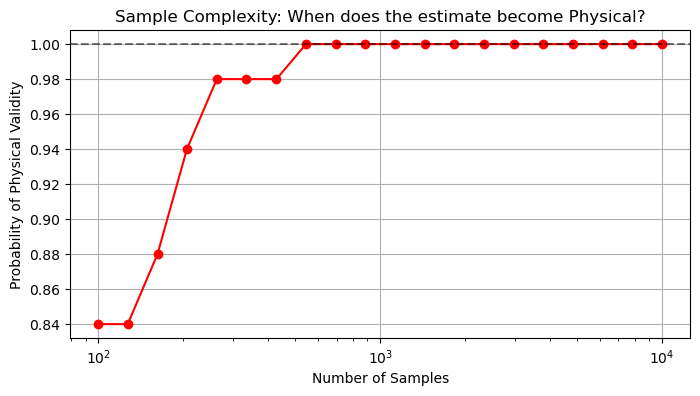

In [6]:
from thewalrus.symplectic import sympmat

def check_cp_validity(X, Y, N_modes):
    """Returns True if the channel satisfies Complete Positivity."""
    Omega = sympmat(N_modes)
    # CP Condition: Y + i*Omega - i*X*Omega*X.T >= 0
    M = Y + 1j * Omega - 1j * (X @ Omega @ X.T)
    min_eig = np.min(np.linalg.eigvalsh(M))
    return min_eig >= -1e-8  # Tolerance for float precision

# --- Configuration ---
low_sample_regime = np.logspace(2, 4, 20).astype(int)  # 100 to 10,000
validity_prob = []

print("Checking Physicality Violations...")
for n in tqdm(low_sample_regime, desc="Low-sample regime"):
    valid_count = 0
    trials = 50

    for _ in range(trials):
        est_X, est_Y = sim.run_tomography(n_samples=n)
        if check_cp_validity(est_X, est_Y, N_modes):
            valid_count += 1

    validity_prob.append(valid_count / trials)

# --- Plotting ---
plt.figure(figsize=(8, 4))
plt.semilogx(low_sample_regime, validity_prob, "r-o")
plt.axhline(1.0, color="k", linestyle="--", alpha=0.5)
plt.xlabel("Number of Samples")
plt.ylabel("Probability of Physical Validity")
plt.title("Sample Complexity: When does the estimate become Physical?")
plt.grid(True)
plt.show()
